In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_raw_df(date='2022-10-01'):
    date = str(date)[:10]
    print(date)
    data_path = r'C:\Users\ke199\Crypto\kronos\chiuan\data\BTCUSDT\BTCUSDT-trades-{}.csv'.format(date)
    df = pd.read_csv(data_path, header=None)
    col = ['ID', 'price', 'size', 'size_quote',
           'trade_time', 'is_buyer_mm', 'ignore']
    df = df.rename(columns=dict(zip(list(df.columns), col)))
    df['is_buyer_mm'] = df['is_buyer_mm'].astype(int)
    return df

def get_vol_kline(df, target_vol):
    data = df.values
    open = 0  # ok
    close = 0  # ok
    high = -np.inf  # ok
    low = np.inf  # ok
    sum = 0  # ok
    sum_usd = 0  # ok
    sum_buy_usd = 0
    ticks = 0  # ok
    buyer_mm = 0  # ok
    start = 0  # ok
    end = 0  # ok
    kline = []
    for tick, i in zip(data, range(len(data))):
        price = tick[1]
        size = tick[2]
        usd = tick[3]
        time = tick[4]
        buy = tick[5]
        buy_usd = buy*usd

        if sum == 0:
            open = price
            start = time

        ticks += 1
        buyer_mm += buy
        sum += size
        sum_usd += usd
        sum_buy_usd += buy_usd

        if price > high:
            high = price

        if price < low:
            low = price

        if sum_usd > target_vol:
            close = price
            end = time
            kline.append([open, high, low, close, sum,
                         sum_usd, start, end, ticks, buyer_mm, sum_buy_usd])
            sum = 0
            sum_usd = 0
            sum_buy_usd = 0
            ticks = 0
            buyer_mm = 0
            high = -np.inf
            low = np.inf

        elif i == len(data)-1:
            close = price
            end = time
            #vwap = sum_usd/sum
            kline.append([open, high, low, close, sum,
                         sum_usd, start, end, ticks, buyer_mm])

    kline_df = pd.DataFrame(kline)
    col = ['open', 'high', 'low', 'close', 'size',
           'size_quote', 'start', 'end', 'ticks', 'seller_taker', 'seller_taker_usd']
    kline_df = kline_df.rename(columns=dict(zip(list(kline_df.columns), col)))
    return kline_df

In [3]:
def get_kline(start='2022-10-01', end='2022-10-02',target_vol = 1000000):
    date_range = pd.date_range(start=start, end=end)
    kline_df_all = pd.DataFrame()

    for date in date_range:
        date = str(date)[:10]
        print(date)
        data_path = r'C:\Users\ke199\Crypto\kronos\chiuan\data\BTCUSDT\BTCUSDT-trades-{}.csv'.format(date)
        try:
            df = pd.read_csv(data_path)
        except:
            print(f'{date} not exist')
            df = get_raw_df(date)
        kline_df = get_vol_kline(df, target_vol)
        kline_df.to_csv(f'{date}_{target_vol}.csv')
        kline_df_all = pd.concat([kline_df_all, kline_df])

    kline_df_all
    # %% 資料處理
    kline_df_all['startTime'] = pd.to_datetime( kline_df_all['start'], unit='ms')
    kline_df_all['endTime'] = pd.to_datetime( kline_df_all['end'], unit='ms')
    kline_df_all = kline_df_all.set_index('startTime')
    kline_df_all['vwap'] = kline_df_all['size_quote']/kline_df_all['size']
    kline_df_all['return'] = kline_df_all['vwap'].pct_change().shift(-1).fillna(0)
    return kline_df_all

In [4]:
def add_position(df,buy_condition,sellshort_condition,sell_condition,buytocover_condition,k_out = np.inf,sp = np.inf,sl = np.inf):    
    position_list = []
    position = 0
    cum_ret = 0
    k = 0
    for index, row in df.iterrows():
        ret = row['return']
        cum_ret += ret
        k += 1
        
        position_list.append(position)
        
        if buy_condition(row) and position == 0:  # buy
            position = 1
            cum_ret = 0
            k = 0
            
        elif sellshort_condition(row) and position == 0:  # sellshort
            position = -1
            cum_ret = 0
            k = 0
            
        elif position == 1 and (sell_condition(row,cum_ret) or k>k_out-1):  # sell
            position = 0
            cum_ret = 0

        elif position == -1 and (buytocover_condition(row,-cum_ret) or k>k_out-1):  # buy to cover
            position = 0
            cum_ret = 0
        
    return position_list

In [5]:
def get_return(df,fee_rate):
    fee_rate = fee_rate/100
    df['fee_rate'] = df['position'].diff().fillna(0).abs()*fee_rate
    df['profit_rate'] = df['position']*df['return']
    df['profit_rate_afterFee'] = df['profit_rate'] - df['fee_rate']
    
    df['long_return'] = df[df['position'] == 1]['return'].cumsum()
    df['long_return'] = df['long_return'].fillna(method = 'ffill').fillna(0)
    df['short_return'] = -df[df['position'] == -1]['return'].cumsum()
    df['short_return'] = df['short_return'].fillna(method = 'ffill').fillna(0)
    
    df['total_profit_rate'] = df['profit_rate'].cumsum()
    df['total_profit_rate_afterFee'] = df['profit_rate_afterFee'].cumsum()
    return df

In [236]:
df_1 = pd.read_csv('2021-03-01_2021-12-31_50000000.csv')
df_2 = pd.read_csv('2022-01-01_2022-10-20_50000000.csv')
df = pd.concat([df_1,df_2])
df['startTime'] = pd.to_datetime(df['start'], unit='ms')
df = df.set_index('startTime')
df

,open,high,low,close,size,size_quote,start,end,ticks,seller_taker,seller_taker_usd,endTime,vwap,return
startTime,,,,,,,,,,,,,,
2021-03-01 00:00:00.161,45134.12,45800.00,44950.53,45800.00,1105.693854,5.005974e+07,1614556800161,1614557793714,26072,12615,2.616396e+07,2021-03-01 00:16:33.714,45274.507234,0.017710
2021-03-01 00:16:33.719,45800.00,46338.22,45750.00,46173.12,1085.191381,5.000163e+07,1614557793719,1614558087409,19751,8699,2.093344e+07,2021-03-01 00:21:27.409,46076.323687,0.004916
2021-03-01 00:21:27.434,46173.12,46571.30,46031.02,46468.02,1081.148877,5.006027e+07,1614558087434,1614558887265,22124,10169,2.024475e+07,2021-03-01 00:34:47.265,46302.841818,0.000898
2021-03-01 00:34:47.265,46464.03,46541.91,46122.24,46233.62,1078.886098,5.000033e+07,1614558887265,1614559914327,21414,10990,2.774059e+07,2021-03-01 00:51:54.327,46344.400614,-0.002301
2021-03-01 00:51:54.371,46233.98,46442.23,46070.01,46072.01,1081.869598,5.002325e+07,1614559914371,1614561085500,21344,10772,2.568088e+07,2021-03-01 01:11:25.500,46237.780861,-0.002742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-20 21:55:24.256,19084.73,19094.44,19025.00,19047.37,2622.807240,5.000042e+07,1666302924256,1666304345390,60256,31536,2.682966e+07,2022-10-20 22:19:05.390,19063.704340,-0.002038
2022-10-20 22:19:05.390,19047.38,19049.42,19000.17,19017.15,2628.807090,5.001266e+07,1666304345390,1666305757464,59827,31102,2.605535e+07,2022-10-20 22:42:37.464,19024.851099,-0.000299
2022-10-20 22:42:37.477,19017.15,19042.56,18982.11,18989.05,2628.994000,5.000129e+07,1666305757477,1666307430088,63138,32296,2.591318e+07,2022-10-20 23:10:30.088,19019.171621,-0.000143


In [7]:
def get_star_pattern(df,co_rate = 0.0025):
    dd= pd.concat([df['CO_rate'].shift(2),df['shadow'].shift(1),df['CO_rate']],axis=1,keys=[-2,-1,0]).fillna(0)
    dd['long'] = ((dd[-2] > co_rate) & (dd[-1] == 1) & (dd[0] < -co_rate)).astype(int)
    dd['short'] = ((dd[-2] < -co_rate) & (dd[-1] == -1) & (dd[0] > co_rate)).astype(int)*-1
    return dd['short']+dd['long']

In [11]:
df['forward_return'] = df['return'].shift(-1).fillna(0)

# 高低、開收震幅
df['HL'] = df['high'] - df['low']
df['AHL'] = df['HL'].rolling(3).mean()/df['close']

df['CO'] = df['close'] - df['open']
df['CO_rate'] = df['CO']/df['open']

# 紅黑K
df['k_color'] = (df['close'] - df['open'])/abs(df['close'] - df['open']) # 漲 1 跌 -1 平 0
df['k_color2'] = df['k_color'].rolling(2).sum().fillna(0)

# 上影線 1 下影線 -1
q = 0.3
df['shadow'] = (df[['close','open']].max(axis=1)<df['low']+df['HL']*q).astype(int) - (df[['close','open']].min(axis=1)>df['high']-df['HL']*q).astype(int)
#df['shadow2'] = df['shadow'].rolling(window=2).sum().fillna(0)

# 滿紅K 1 滿黑K -1
fill_rate = 0.75
df['fill_rate'] = abs(df['CO'])/df['HL']

# star
# df['star'] = get_star_pattern(df,co_rate = 0.025)

In [12]:
def shadow_break(df,shadow_rate = 0.3,break_rate = 0):
    dd = df.copy()
    dd['shadow'] = (dd[['close','open']].max(axis=1)<dd['low']+dd['HL']*shadow_rate).astype(int) - (dd[['close','open']].min(axis=1)>dd['high']-dd['HL']*shadow_rate).astype(int)
    dd['pre_shadow'] = dd['shadow'].shift()
    dd['break_rate'] = dd['close'].pct_change().fillna(0)
    dd['long'] = ((dd['pre_shadow'] == 1) & (dd['k_color'] == 1) & (dd['break_rate'] > break_rate)).astype(int)
    dd['short'] = ((dd['pre_shadow'] == -1) & (dd['k_color'] == -1) & (dd['break_rate'] < break_rate)).astype(int)*(-1)
    return dd['short']+dd['long']

<AxesSubplot:xlabel='startTime'>

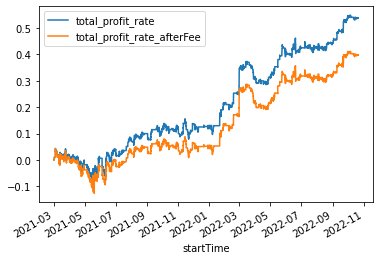

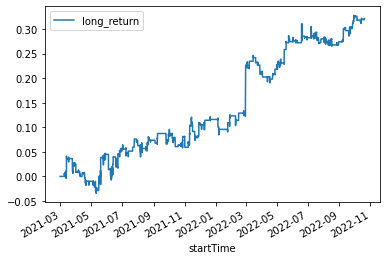

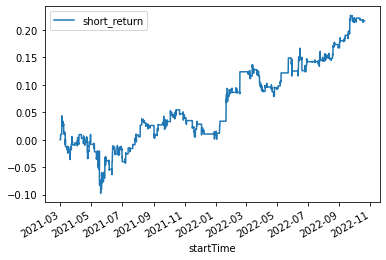

In [224]:
sl = 1
sp = 2.5

def buy_condition(row):
    if row['shadow_break'] == 1:
        return True
    return False

def sellshort_condition(row):
    if row['shadow_break'] == -1:
        return True
    return False

def sell_condition(row,cum_ret):
#     if cum_ret < -(sl/100) or cum_ret > sp/100:
#         return True
    return False

def buytocover_condition(row,cum_ret):
#      if cum_ret < -(sl/100) or cum_ret > sp/100:
#         return True
     return False

df['shadow_break'] = shadow_break(df,shadow_rate = 0.2,break_rate = 0/100)
df['position'] = add_position(df,buy_condition,sellshort_condition,sell_condition,buytocover_condition,k_out=5)
df = get_return(df,fee_rate = 0.015)

df[['total_profit_rate','total_profit_rate_afterFee']].plot()
df[['long_return']].plot()
df[['short_return']].plot()

<AxesSubplot:title={'center':'forward return'}>

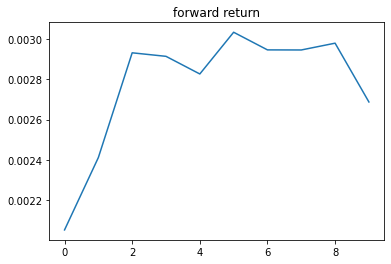

In [152]:
avg_return_list = []
for win in range(1,11):
    dd = pd.concat([df['shadow_break'],df['return'].rolling(win).sum().shift(-win+1)],axis=1)
    long_avg_ret = dd[dd['shadow_break'] == 1]['return'].mean()
    short_avg_ret = -dd[dd['shadow_break'] == -1]['return'].mean()
    avg_ret = (dd['shadow_break'] * dd['return'])
    avg_ret = avg_ret[avg_ret!=0].mean()
    avg_return_list.append([long_avg_ret,short_avg_ret,avg_ret])

plot_df = (pd.DataFrame(avg_return_list,columns = ['long_avg_ret','short_avg_ret','avg_ret']))
plot_df['avg_ret'].plot(title='forward return')

In [171]:
def get_MDD(cum_trade_percent_return):
    MDD_series = cum_trade_percent_return.cummax()-cum_trade_percent_return
    MDD = MDD_series.max()
    return MDD

In [182]:
def get_sharpe(cum_trade_percent_return):
    daily_return = cum_trade_percent_return.resample('D').last().diff().fillna(0)
    sharpe = (daily_return.mean()/daily_return.std())*pow(365,0.5)
    return sharpe

In [193]:
result_list = []
for sl in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]:
    for sp in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]:

        def buy_condition(row):
            if row['shadow_break'] == 1:
                return True
            return False

        def sellshort_condition(row):
            if row['shadow_break'] == -1:
                return True
            return False

        def sell_condition(row,cum_ret):
            if cum_ret < -(sl/100) or cum_ret > sp/100:
                return True
            return False

        def buytocover_condition(row,cum_ret):
             if cum_ret < -(sl/100) or cum_ret > sp/100:
                return True
             return False

        df['shadow_break'] = shadow_break(df,shadow_rate = 0.2,break_rate = 0/100)
        df['position'] = add_position(df,buy_condition,sellshort_condition,sell_condition,buytocover_condition,k_out=5)
        df = get_return(df,fee_rate = 0.015)
        total_return = df['total_profit_rate_afterFee'].iloc[-1]
        mdd = get_MDD(df['total_profit_rate_afterFee'])
        sharpe = get_sharpe(df['total_profit_rate_afterFee'])
        print([sl,sp,total_return,mdd,sharpe])
        result_list.append([sl,sp,total_return,mdd,sharpe])

[0.5, 0.5, 0.12391899173914833, 0.1166165160120264, 0.5968646951668658]
[0.5, 1, 0.28819948742439877, 0.101516110935466, 1.2851741646188495]
[0.5, 1.5, 0.3013426916268926, 0.10923408434043091, 1.2444281424360066]
[0.5, 2, 0.30620696338343617, 0.10923408434043104, 1.2462205709501561]
[0.5, 2.5, 0.33931125180378524, 0.1092340843404313, 1.3628502106723783]
[0.5, 3, 0.34276985097921814, 0.10923408434043128, 1.3753084633215826]
[0.5, 3.5, 0.33635058270380186, 0.10923408434043122, 1.3533640925071335]
[0.5, 4, 0.34537565533419606, 0.10923408434043125, 1.378076647363877]
[0.5, 4.5, 0.3576986983485723, 0.1092340843404313, 1.4034604551683647]
[0.5, 5, 0.3576986983485723, 0.1092340843404313, 1.4034604551683647]
[1, 0.5, 0.1701186090634922, 0.13130236202782966, 0.7742233389078855]
[1, 1, 0.3368130012868857, 0.12007373475186552, 1.3896035421678363]
[1, 1.5, 0.3570432052401134, 0.13295704327659674, 1.35189929486076]
[1, 2, 0.37030783004156026, 0.12408187980748567, 1.3662015390686186]
[1, 2.5, 0.4034

In [206]:
best = pd.DataFrame(result_list,columns=['stop loss','stop profit','total_return','mdd','sharpe'])

In [222]:
best

,stop loss,stop profit,total_return,mdd,sharpe
0,0.5,0.5,0.123919,0.116617,0.596865
1,0.5,1.0,0.288199,0.101516,1.285174
2,0.5,1.5,0.301343,0.109234,1.244428
3,0.5,2.0,0.306207,0.109234,1.246221
4,0.5,2.5,0.339311,0.109234,1.362850
...,...,...,...,...,...
95,5.0,3.0,0.383044,0.169209,1.314704
96,5.0,3.5,0.376625,0.169209,1.293785
97,5.0,4.0,0.385650,0.169209,1.312657
98,5.0,4.5,0.397973,0.169209,1.327477


<AxesSubplot:xlabel='stop profit', ylabel='stop loss'>

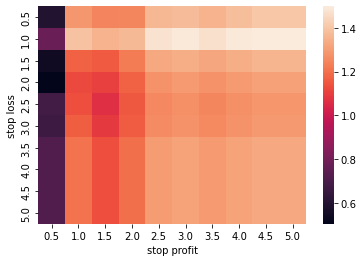

In [221]:
sns.heatmap(best[['stop loss','stop profit','sharpe']].pivot('stop loss','stop profit','sharpe'))

In [367]:
df = pd.read_csv('2021-03-01_2022-10-20-_50000000.csv')
df['startTime'] = pd.to_datetime(df['start'], unit='ms')
df = df.set_index('startTime')


In [368]:
from fastdtw import fastdtw

def get_target_date(date = '2022-05-03',window = '10D'):
    target_ts = df['close'].loc[date]
    # 往回找window天最像的
    start_date = str(pd.to_datetime(date) - pd.Timedelta(window))[:10]
    dates = list(pd.date_range(start_date,date)[:-1])
    max_dis = -np.inf
    best_date = ''
    for dt in dates:
        dt = str(dt)[:10]
        test_ts = df['close'].loc[dt]
        distance, path = fastdtw(target_ts,test_ts)
        if distance > max_dis:
            max_dis = distance
            best_date = dt
            #print(dt, distance)
    return best_date

In [ ]:
start_date = '2022-01-01'
end_date = '2022-10-20'
window = '7D'

_mapping = {}

for date in pd.date_range(start = start_date,end = end_date):
    date = str(date)[:10]
    print(date)
    target = get_target_date(date = date,window = window)
    _mapping[date] = target

2022-01-01
2022-01-02
2022-01-03
2022-01-04
2022-01-05
2022-01-06
2022-01-07
2022-01-08
2022-01-09
2022-01-10
2022-01-11
2022-01-12
2022-01-13
2022-01-14
2022-01-15
2022-01-16
2022-01-17
2022-01-18
2022-01-19
2022-01-20
2022-01-21
2022-01-22
2022-01-23
2022-01-24
2022-01-25
2022-01-26
2022-01-27
2022-01-28
2022-01-29
2022-01-30
2022-01-31
2022-02-01
2022-02-02
2022-02-03
2022-02-04
2022-02-05
2022-02-06
2022-02-07
2022-02-08
2022-02-09
2022-02-10
2022-02-11
2022-02-12
2022-02-13
2022-02-14
2022-02-15
2022-02-16
2022-02-17
2022-02-18
2022-02-19
2022-02-20
2022-02-21
2022-02-22
2022-02-23
2022-02-24
2022-02-25
2022-02-26
2022-02-27
2022-02-28
2022-03-01
2022-03-02
2022-03-03
2022-03-04
2022-03-05
2022-03-06
2022-03-07
2022-03-08
2022-03-09
2022-03-10
2022-03-11
2022-03-12
2022-03-13
2022-03-14
2022-03-15
2022-03-16
2022-03-17
2022-03-18
2022-03-19
2022-03-20
2022-03-21
2022-03-22
2022-03-23
2022-03-24
2022-03-25
2022-03-26
2022-03-27
2022-03-28
2022-03-29
2022-03-30
2022-03-31
2022-04-01

<AxesSubplot:>

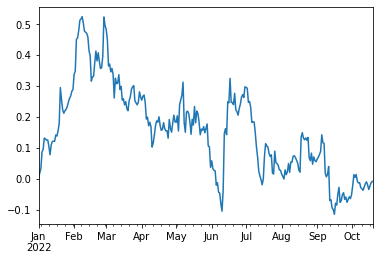

In [378]:
return_df = df['close'].resample('1D').last().pct_change(-1).fillna(0)
signal_df = return_df.apply(lambda x :1 if x> 0 else -1)
signals = []
for date in pd.date_range(start_date,end_date):
    signals.append(signal_df.loc[_mapping[str(date)[:10]]])
    
result_df = pd.concat([pd.Series(list(pd.date_range(start_date,end_date))),pd.Series(signals)],axis = 1,keys=['date','signal'])
result_df['signal'] = result_df['signal'].shift().fillna(0)
result_df = result_df.set_index('date')
result_df = pd.concat([result_df,return_df],axis=1).dropna().rename(columns={'close':'return'})
(result_df['signal']*result_df['return']).cumsum().plot()